# TPC based Cosmic Rate measurement

## Imports

In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import glob
import time
from IPython.display import display, clear_output
import pandas as pd
from scipy.stats import circmean, circstd
import helpfunction as helper
%matplotlib inline

pd.options.display.max_columns=999

## Constants

In [2]:
main_tree_name = 'cosmicstudies'

# Input files
file_name_mc = './input/CosmicStudiesCRT_mc_75k_mcc9.root'
file_name_data = './input/CosmicStudiesCRT_run3_48k_mcc9.root'

outdir = './Output/CosmicPfp/'

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])

gr = 1.618           # Golden ratio
good_start = -0.4e6  # Start of MC time where we are not biased by out of time charge
good_end = 0.4e6    # End of good MC time window (in ns)
t_begin = good_start/1e6
t_end = good_end/1e6
scatter_fraq = 0.05     # Number of points to include in scatter plots

per1 = 50-68.27/2
per2 = 50+68.27/2

## Functions

In [3]:
# Function should be able to work with arrays!
def cosmic_angles(mom_x, mom_y, mom_z,df_out=True):
    mask_flip_dir = (mom_y>0)*2-1
    mom_x, mom_y, mom_z = mask_flip_dir*mom_x,mask_flip_dir*mom_y,mask_flip_dir*mom_z
    
    theta_cosmic = np.arctan2(np.sqrt(np.square(mom_x)+np.square(mom_z)),mom_y)
    phi_cosmic = np.arctan2(mom_x,mom_z)
    if df_out:
        return pd.DataFrame({'zenith':theta_cosmic, 'azimuth':phi_cosmic})[['zenith','azimuth']]
    else:
        return np.array([theta_cosmic, phi_cosmic])

In [4]:
cosmic_angles(1,-1,0,df_out=False)

array([ 0.78539816, -1.57079633])

In [5]:
def cosmic_angles_start_end(x_s, y_s, z_s, x_e, y_e, z_e, df_out=True):
    return cosmic_angles(x_s-x_e, y_s-y_e, z_s-z_e, df_out)

In [6]:
cosmic_angles_start_end(-41.974457, 116.995811, 396.336456, 138.189041, -103.982864, 444.623535, df_out=False)

array([ 0.70104321, -1.83266001])

In [7]:
# To Do: update for logspace x axis
def histHelper(N,x_min,x_max,data,weights=0):
    edges = np.linspace(x_min,x_max,N+1)
    edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
    bins = [np.histogram(data_i,bins=edges)[0] for data_i in data]
    max_val = max([max(x) for x in bins])
    if weights==0:
        err = np.sqrt(bins)
    else:
        err = [helper.hist_bin_uncertainty(d_i, w_i, edges) for d_i, w_i in zip(data,weight)] 
    return edges, edges_mid, bins, err, max_val

## Load the data

In [8]:
file_mc = uproot.open(file_name_mc)[main_tree_name]
file_data = uproot.open(file_name_data)[main_tree_name]

In [9]:
file_mc.keys()

[b'pot;1',
 b'Event;1',
 b'MCParticles;1',
 b'OpBeamFlashes;1',
 b'SimpleBeamFlashes;1',
 b'OpCosmicFlashes;1',
 b'SimpleCosmicFlashes;1',
 b'PFParticles;1',
 b'Clusters;1',
 b'CRTcross;1']

In [10]:
file_mc[b'Event'].keys()

[b'event',
 b'run',
 b'subrun',
 b'pot',
 b'dataset_prescale_factor',
 b'num_simplebeamflashes',
 b'num_opbeamflashes',
 b'num_simplecosmicflashes',
 b'num_opcosmicflashes',
 b'num_pfp',
 b'num_pfp_saved',
 b'num_mcp',
 b'num_mcp_saved',
 b'num_nu',
 b'nu_vtx_x',
 b'nu_vtx_y',
 b'nu_vtx_z',
 b'nu_E',
 b'nu_time',
 b'nu_pdg_code',
 b'nu_ccnc']

In [11]:
# Load events df
cols = [b'event', b'run', b'subrun', 
        b'num_pfp', b'num_pfp_saved', b'num_mcp', b'num_mcp_saved']

df_event_mc = file_mc[b'Event'].pandas.df(cols)
df_event_data = file_data[b'Event'].pandas.df()

n_mc = len(df_event_mc)
n_data = len(df_event_data)
mc_scale = n_data/n_mc
print("Events in MC: ", n_mc, "\t Events in data: ", n_data,".")

Events in MC:  80000 	 Events in data:  49041 .


In [12]:
df_event_mc.keys()

Index(['event', 'run', 'subrun', 'num_pfp', 'num_pfp_saved', 'num_mcp',
       'num_mcp_saved'],
      dtype='object')

In [13]:
# Load mcp df
df_mcp = file_mc[b'MCParticles'].pandas.df()
# Add the true zenith/azimuth angles at generation
cols = ['mc_startmomentumx', 'mc_startmomentumy', 'mc_startmomentumz']
df_mcp[['mc_zenith_true','mc_azimuth_true']] = cosmic_angles(*df_mcp[cols].T.values)
cols = ['mc_startx_tpc', 'mc_starty_tpc', 'mc_startz_tpc', 
        'mc_endx_tpc', 'mc_endy_tpc', 'mc_endz_tpc']
df_mcp[['mc_zenith_traj','mc_azimuth_traj']] = cosmic_angles_start_end(*df_mcp[cols].T.values)
df_mcp['time_drift_ok'] = df_mcp['mc_time'].between(good_start,good_end)
df_mcp.keys()
print("Memory usage in megabyte: {0:.1f}".format(df_mcp.memory_usage(index=True, deep=True).sum()*1e-6))

Memory usage in megabyte: 3078.7


In [14]:
print(df_mcp.query("mc_is_matched==1")['mc_pdg_code'].value_counts())

 2112    4182443
-13       923257
 13       802009
 2212     622047
 11       390440
 22       258126
-11       127021
 211       14459
-211       10264
 111        6703
-2212         26
-2112         16
Name: mc_pdg_code, dtype: int64


In [15]:
# Load pfp df
df_pfp_mc = file_mc[b'PFParticles'].pandas.df()
df_pfp_data = file_data[b'PFParticles'].pandas.df()

# Add the reco zenith/azimuth angles fro reco particles based on the start momentum
cols= ['track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz']
df_pfp_mc[['pfp_zenith_start','pfp_azimuth_start']] = cosmic_angles(*df_pfp_mc[cols].T.values)
df_pfp_data[['pfp_zenith_start','pfp_azimuth_start']] = cosmic_angles(*df_pfp_data[cols].T.values)
# Add the reco zenith/azimuth angles fro reco particles based on the trajectory
cols = ['track_startx', 'track_starty', 'track_startz', 'track_endx', 'track_endy', 'track_endz']
df_pfp_mc[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df_pfp_mc[cols].T.values)
df_pfp_data[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df_pfp_data[cols].T.values)

# Add the true zenith/azimuth angles at generation
cols = ['track_matched_startmomentumx', 'track_matched_startmomentumy', 'track_matched_startmomentumz']
df_pfp_mc[['mc_zenith_true','mc_azimuth_true']] = cosmic_angles(*df_pfp_mc[cols].T.values)
# Add the reco zenith/azimuth angles for tuth particles based on the trajectory
cols = ['track_matched_startx_sce', 'track_matched_starty_sce', 'track_matched_startz_sce', 
        'track_matched_endx_sce', 'track_matched_endy_sce', 'track_matched_endz_sce']
df_pfp_mc[['mc_zenith_traj','mc_azimuth_traj']] = cosmic_angles_start_end(*df_pfp_mc[cols].T.values)

# Add if tracks are broken:
df_pfp_mc['broken_pfp'] = df_pfp_mc.duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
df_pfp_mc['time_drift_ok'] = df_pfp_mc['track_matched_time'].between(good_start,good_end)
df_pfp_mc['mc_avgx'] = (df_pfp_mc['track_matched_startx']+df_pfp_mc['track_matched_endx'])/2
df_pfp_mc['mc_avgx_sce'] = (df_pfp_mc['track_matched_startx_sce']+df_pfp_mc['track_matched_endx_sce'])/2

In [16]:
print(df_pfp_mc.keys())
print("Memory usage in megabyte: {0:.1f}".format(df_pfp_mc.memory_usage(index=True, deep=True).sum()*1e-6))

Index(['event', 'run', 'subrun', 'num_pfp', 'num_mcp', 'num_mcp_saved',
       'num_flashes', 'pdg_code', 'num_daughters', 'is_primary', 'n_hits',
       'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
       'track_startx', 'track_starty', 'track_startz', 'track_endx',
       'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
       'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
       'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
       'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
       'track_mcs_momentum', 'track_mcs_mom_err', 'track_mcs_likelihood',
       'track_mcs_energy', 'track_matched_pdgcode', 'track_matched_energy',
       'track_matched_kBeamNeutrino', 'track_matched_time',
       'track_matched_process', 'track_matched_end_process',
       'track_matched_startinside', 'track_matched_endinside',
       'track_matched_partinside', 'track_matched_startx',
       'track_matched_starty', 't

In [17]:
df_pfp_mc['is_primary']

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
           ... 
1878332    True
1878333    True
1878334    True
1878335    True
1878336    True
1878337    True
1878338    True
1878339    True
1878340    True
1878341    True
1878342    True
1878343    True
1878344    True
1878345    True
1878346    True
1878347    True
1878348    True
1878349    True
1878350    True
1878351    True
1878352    True
1878353    True
1878354    True
1878355    True
1878356    True
1878357    True
1878358    True
1878359    True
1878360    True
1878361    True
Name: is_primary, Length

## DataFrame preparation

In [18]:
# 1. All inTPC muons, mcparticles
primary_query = '(mc_process==23)'
muon_query = '(mc_pdg_code==13 | mc_pdg_code==-13)'
intpc_query = '(mc_length_tpc>5)' 
clean_query =  "(track_length>25)"
df_mc_muon_cross = df_mcp.query(primary_query+' & '+muon_query+ ' & '+intpc_query)
# Save your memory!
del df_mcp

# Remove beam neutrino content
nu_ori_mc = "(mc_neutrino_origin==0)"
nu_ori_reco = "(track_matched_kBeamNeutrino==0)"
df_pfp_mc = df_pfp_mc.query(nu_ori_reco)
df_mc_muon_cross = df_mc_muon_cross.query(nu_ori_mc)

# 2. All matched inTPC muons, deduplicated
primary_matched_query = '(track_matched_process==23)'
muon_matched_query = '(track_matched_pdgcode==13 | track_matched_pdgcode==-13)'
intpc_matched_query = '(track_matched_length_tpc>0)' 
matched_query = primary_matched_query+' & '+muon_matched_query+ ' & '+intpc_matched_query
df_pfp_matched_unique = df_pfp_mc.drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched = df_pfp_matched_unique.query(matched_query)

# 3. Split the reconstructed tracks in 3 categories:
query_cat1 = '((track_matched_pdgcode==13) | (track_matched_pdgcode==-13)) & (broken_pfp==0)'
query_cat2 = '((track_matched_pdgcode==13) | (track_matched_pdgcode==-13)) & (broken_pfp==1)'
query_cat3 = '((track_matched_pdgcode!=13) & (track_matched_pdgcode!=-13))'
query_arr = [query_cat1, query_cat2, query_cat3]
label_arr = ['Muon matched', 'Muon matched, broken', 'Other matched']
df_arr = [df_pfp_mc.query(q) for q in query_arr]

## Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a40f8a400>]],
      dtype=object)

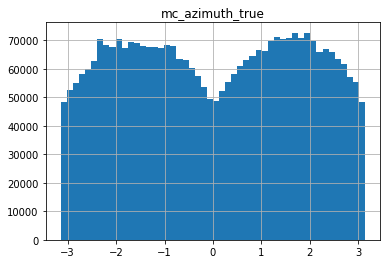

In [28]:
df_mc_muon_cross.hist('mc_azimuth_true', bins=50)

[22.63937848446211, 18.119084031728555]
[0.022422026439522125, 0.023299554196079344]
Deficit of reconstructed 5cm + tracks in data:  19.97%
[18.79534488362209, 14.874166513733407]
[0.018137603262635364, 0.017662811292675433]
Deficit of reconstructed 5cm + tracks in data:  20.9%


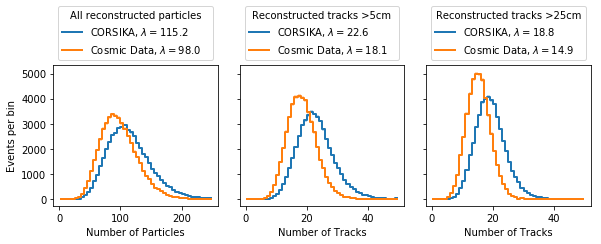

In [19]:
fig, ax = plt.subplots(ncols = 3, sharey=True, figsize=(8.5,3.5))
labs=['CORSIKA', 'Cosmic Data']

field = 'num_pfp'
N=50
x_min = 0
x_max = 250
data = [df_event_mc[field], df_event_data[field]]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
means = ([x.mean() for x in data])
weights = [mc_scale, 1]
for b_i, w_i, lab_i, err_i, mu_i in zip(bins,weights,labs, err, means):
    b_i = np.array(b_i)*w_i
    err_i = err_i*w_i
    ax[0].step(edges_mid,b_i,lw=2, label=lab_i+r', $\lambda=${0:.1f}'.format(mu_i), where='mid')
    ax[0].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='All reconstructed particles', loc='lower center', mode='expand')
ax[0].set_xlabel("Number of Particles")
ax[0].set_ylabel("Events per bin")

field = 'num_pfp_saved'
x_max = 50
#data = [df_event_mc[field], df_event_data[field]]
data = [df_pfp_mc.groupby(['run', 'subrun', 'event', 'num_mcp']).size(),
        df_pfp_data.groupby(['run', 'subrun', 'event']).size()]
means= [x.mean() for x in data]
means_err = [x.std()/np.sqrt(len(x)) for x in data]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for b_i, w_i, lab_i, err_i, mu_i in zip(bins,weights,labs, err, means):
    b_i = np.array(b_i)*w_i
    err_i = err_i*w_i
    ax[1].step(edges_mid,b_i,lw=2, label=lab_i+r', $\lambda=${0:.1f}'.format(mu_i), where='mid')
    ax[1].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Reconstructed tracks >5cm', loc='lower center', mode='expand')
ax[1].set_xlabel("Number of Tracks")
print(means)
print(means_err)
print('Deficit of reconstructed 5cm + tracks in data:  {0:.2f}%'.format(100-means[1]/means[0]*100))


x_max=50
clean_tracks = [df_pfp_mc.query(clean_query).groupby(['run', 'subrun', 'event', 'num_mcp']).size(),
                df_pfp_data.query(clean_query).groupby(['run', 'subrun', 'event']).size()]
means= [x.mean() for x in clean_tracks]
means_err = [x.std()/np.sqrt(len(x)) for x in clean_tracks]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, clean_tracks)
for b_i, w_i, lab_i, err_i, mu_i in zip(bins,weights,labs, err, means):
    b_i = np.array(b_i)*w_i
    err_i = err_i*w_i
    ax[2].step(edges_mid,b_i,lw=2, label=lab_i+r', $\lambda=${0:.1f}'.format(mu_i), where='mid')
    ax[2].fill_between(edges_mid, b_i - err_i, b_i + err_i, alpha=0.3, step='mid')
ax[2].set_xlabel("Number of Tracks")
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Reconstructed tracks >25cm', loc='lower center', mode='expand')
print(means)
print(means_err)
print('Deficit of reconstructed 5cm + tracks in data:  {0:.1f}%'.format(100-means[1]/means[0]*100))

fig.tight_layout()
plt.savefig(outdir+"num_pfp.pdf", bbox_inches="tight")

In [20]:
# How often is a reco primary track of 5cm matched to a muons? 95% of the cases to a muon
df_pfp_mc['track_matched_pdgcode'].value_counts()/len(df_pfp_mc)*100
df_pfp_matched_unique = df_pfp_mc.drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched = df_pfp_matched_unique.query(matched_query)

In [21]:
# How often does a good mc muon get matched? only 50% of the time!
# What happens to the other muons? True time dependency?
print('Reconstruction efficiency, no time cut:')
counts= df_mc_muon_cross['mc_is_matched'].value_counts()
print("All pfp, Fraction of true crossing muons that was matched",counts[True]/sum(counts)*100)
print("5cm+\t Fraction of true crossing muons that was matched",len(df_mc_muon_cross_matched)/sum(counts)*100)
df_pfp_matched_unique_25 = df_pfp_mc.query(clean_query).drop_duplicates(subset=['track_matched_time', 'track_matched_energy'])
df_mc_muon_cross_matched_25 = df_pfp_matched_unique_25.query(matched_query)
print("25cm+\t Fraction of true crossing muons that was matched",len(df_mc_muon_cross_matched_25)/sum(counts)*100)

Reconstruction efficiency, no time cut:
All pfp, Fraction of true crossing muons that was matched 52.27013184103196
5cm+	 Fraction of true crossing muons that was matched 51.16402668437193
25cm+	 Fraction of true crossing muons that was matched 46.666476967340095


In [22]:
lent = sum([len(x) for x in df_arr])
print(len(df_arr[0])/lent)
print(len(df_arr[1])/lent)
print(len(df_arr[2])/lent)

0.8489601652030114
0.10576416055391598
0.0452756742430726


In [23]:
# Purity comparison if the track is 5cm+ or 25cm+:
print("Muon PDG Purity:")
frq = len(df_pfp_mc.query(muon_matched_query))/len(df_pfp_mc)
print('5cm+\tFraction of reco tracks matched to true muons:',frq,' +/-',np.sqrt((1-frq)*frq/len(df_pfp_mc)))
frq = len(df_pfp_mc.query(clean_query).query(muon_matched_query))/len(df_pfp_mc.query(clean_query))
print('25cm+\tFraction of reco tracks matched to true muons:',frq*100,' +/-',100*np.sqrt((1-frq)*frq/len(df_pfp_mc.query(clean_query))))

# Caluclation of broken tracks if it is a muon!
#After 5cm cut
broken_pure_bool = df_pfp_mc.query(muon_matched_query)['broken_pfp']
print('Fraction of reco tracks that are broken:', sum(broken_pure_bool)/len(broken_pure_bool)*100)
broken_pure_bool = df_pfp_mc.query(muon_matched_query).groupby(['track_matched_time', 'track_matched_energy']).size()
print('Fraction of true tracks that are broken:', sum(broken_pure_bool>1)/len(broken_pure_bool)*100)
#After 25cm cut:
broken_pure_bool = df_pfp_mc.query(clean_query).query(muon_matched_query).duplicated(subset=['track_matched_time', 'track_matched_energy'], keep=False)
print('Fraction of reco tracks that are broken:', sum(broken_pure_bool)/len(broken_pure_bool)*100)
broken_pure_bool = df_pfp_mc.query(clean_query).query(muon_matched_query).groupby(['track_matched_time', 'track_matched_energy']).size()
print('Fraction of true tracks that are broken:', sum(broken_pure_bool>1)/len(broken_pure_bool)*100)

Muon PDG Purity:
5cm+	Fraction of reco tracks matched to true muons: 0.9547243257569274  +/- 0.00015448974011907332
25cm+	Fraction of reco tracks matched to true muons: 99.0321164679201  +/- 0.007984263593115378
Fraction of reco tracks that are broken: 11.077979024999046
Fraction of true tracks that are broken: 5.127202048560762
Fraction of reco tracks that are broken: 1.6154064674014146
Fraction of true tracks that are broken: 0.7597891612174239


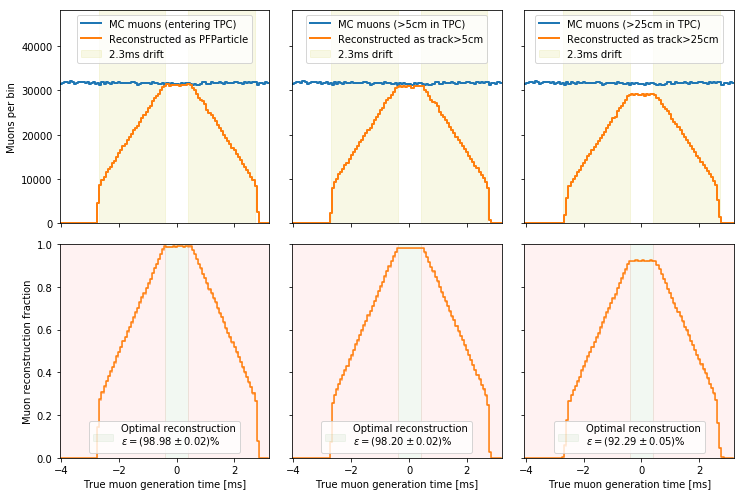

In [25]:
fig, ax = plt.subplots(ncols = 3, nrows=2, sharey='row', sharex=True, figsize=(10.5,7))
N=100
x_min=min(df_mc_muon_cross['mc_time']/1e6)
x_max=max(df_mc_muon_cross['mc_time']/1e6)

nom_labs  =['Reconstructed as PFParticle', 'Reconstructed as track>5cm', 'Reconstructed as track>25cm']
denom_arr   = [df_mc_muon_cross['mc_time']/1e6, 
             df_mc_muon_cross.query("mc_length_tpc>0")['mc_time']/1e6, 
             df_mc_muon_cross.query("mc_length_tpc>0")['mc_time']/1e6]
denom_labs = ['MC muons (entering TPC)', 'MC muons (>5cm in TPC)', 'MC muons (>25cm in TPC)']
nom_arr =[df_mc_muon_cross.query("mc_is_matched==1")['mc_time']/1e6, 
            df_mc_muon_cross_matched.query('track_matched_length_tpc>0')['track_matched_time']/1e6,
            df_mc_muon_cross_matched_25.query('track_matched_length_tpc>0')['track_matched_time']/1e6]

edges, edges_mid, nom_bins, nom_errs, max_y = histHelper(N, x_min, x_max, nom_arr)
_, _, denom_bins, denom_errs, max_y = histHelper(N, x_min, x_max, denom_arr)

iterable = enumerate(zip(nom_arr, nom_labs,nom_bins, nom_errs, denom_arr, denom_labs, denom_bins, denom_errs))
for i,(nom, nom_lab,nom_bin, nom_err, denom, denom_lab, denom_bin, denom_err) in iterable:
    # Upper row
    ax[0][i].step(edges_mid, denom_bin, lw=2, label=denom_lab, where='mid')
    ax[0][i].fill_between(edges_mid, denom_bin - denom_err, denom_bin - denom_err, alpha=0.3, step='mid') 
    ax[0][i].step(edges_mid, nom_bin, lw=2, label=nom_lab, where='mid')
    ax[0][i].fill_between(edges_mid, nom_bin - nom_err, nom_bin - nom_err, alpha=0.3, step='mid')
    ax[0][i].set_ylim(0,max_y*1.5)
    ax[0][i].set_xlim(x_min,x_max)
    ax[0][i].axvspan(t_begin-2.3,t_begin, alpha=0.1, color="y", label='2.3ms drift')
    ax[0][i].axvspan(t_end,t_end+2.3, alpha=0.1, color="y")
    ax[0][i].legend(loc='upper center')
    
    # Lower row
    ratio = sum(nom.between(t_begin,t_end))/sum(denom.between(t_begin,t_end))
    ratio_err = np.sqrt((1-ratio)*ratio/sum(denom.between(t_begin,t_end)))
    fraq = nom_bin/denom_bin
    err = np.sqrt( fraq*(1-fraq)/denom_bin )
    ax[1][i].step(edges_mid, fraq, where='mid',color="C1")
    ax[1][i].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')
    ax[1][i].set_ylim(0,1)
    ax[1][i].axvspan(x_min,t_begin, alpha=0.05, color="red")
    ratio_str = r'$\varepsilon = ({0:.2f}\pm{1:.2f})\%$'.format(ratio*100,ratio_err*100)
    ax[1][i].axvspan(t_begin,t_end, alpha=0.05, color="green", label='Optimal reconstruction\n'+ratio_str)
    ax[1][i].axvspan(t_end,x_max, alpha=0.05, color="red")
    ax[1][i].set_xlabel(r'True muon generation time [ms]')
    ax[1][i].legend(loc='lower center')
    
ax[0][0].set_ylabel(r'Muons per bin')
ax[1][0].set_ylabel(r'Muon reconstruction fraction')

fig.tight_layout()
fig.savefig(outdir+"match_eff.pdf", bbox_inches="tight")

Estimated size of the systematic due to the CORSIKA bug is -0.01%


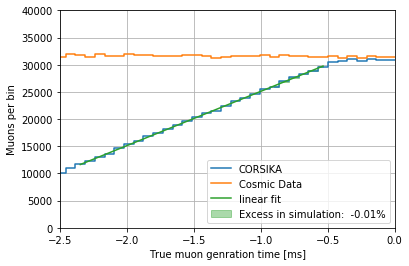

In [24]:
# Try to quantify the excess in Matched mc muons!
import numpy.polynomial.polynomial as poly

plt.step(edges_mid,nom_bins[1],where='mid', label=labs[0])
plt.step(edges_mid,denom_bins[1],where='mid', label=labs[1])
plt.xlim(-2.5,0)
plt.ylim(0,40000)
plt.grid(True)
plt.xlabel("True muon genration time [ms]")
plt.ylabel("Muons per bin")

mask = (-2.4<np.array(edges_mid)) & (np.array(edges_mid)<-0.9)
x = np.array(edges_mid)[mask]
y = np.array(nom_bins[1])[mask]
coefs = np.polyfit( x,y,1)

mask = (-2.4<np.array(edges_mid)) & (np.array(edges_mid)<-0.5)
x_new = np.array(edges_mid)[mask]
ffit = poly.polyval(x_new, coefs[::-1])
plt.plot(x_new,ffit, label = 'linear fit')

mask = (-0.9<np.array(edges_mid)) & (np.array(edges_mid)<-0.5)
y_fit = poly.polyval(np.array(edges_mid)[mask], coefs[::-1])
syst_frq = sum(np.array(nom_bins[1])[mask] - y_fit)/sum(nom_bins[1])
plt.fill_between(np.array(edges_mid)[mask], y_fit , np.array(nom_bins[1])[mask], alpha=0.4, step='mid', 
                 label= "Excess in simulation:  {0:.2f}%".format(syst_frq*100), color='C2')
print("Estimated size of the systematic due to the CORSIKA bug is {0:.2f}%".format(syst_frq*100))
plt.legend()
fig.tight_layout()
plt.savefig(outdir+"corsika_bug_est.pdf", bbox_inches="tight")

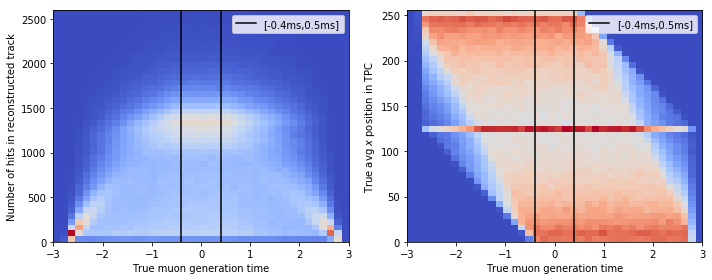

In [25]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(10,4))

ax[0].hist2d(df_mc_muon_cross_matched['track_matched_time']/1e6,df_mc_muon_cross_matched['n_hits'],range=((-3,3),(0,2600)), bins=(40,40), cmap="coolwarm")
ax[0].set_xlabel('True muon generation time')
ax[0].set_ylabel('Number of hits in reconstructed track')
ax[0].axvline(x=t_begin,color='k', label='[-0.4ms,0.5ms]')
ax[0].axvline(x=t_end,color='k')
ax[0].legend()

ax[1].hist2d(df_mc_muon_cross_matched['track_matched_time']/1e6,df_mc_muon_cross_matched['mc_avgx'],range=((-3,3),(0,256)), bins=(40,40), cmap="coolwarm")
ax[1].set_xlabel('True muon generation time')
ax[1].set_ylabel(r'True avg $x$ position in TPC')
ax[1].axvline(x=t_begin,color='k', label='[-0.4ms,0.5ms]')
ax[1].axvline(x=t_end,color='k')
ax[1].legend()
fig.tight_layout()
plt.savefig(outdir+"mc_time_2d.pdf", bbox_inches="tight")

In [26]:
df_pfp_mc['track_matched_pdgcode'].value_counts()

-13      945221
 13      783885
 2112     28674
 22       27189
 2212      8305
 11        8217
-11        7941
 211        903
-211        627
-2212        84
 321         27
-321         19
-2112         6
-3222         3
 3112         2
 3222         1
 3312         1
Name: track_matched_pdgcode, dtype: int64

In [27]:
df_pfp_mc.query('broken_pfp')['track_matched_pdgcode'].value_counts()*100/df_pfp_mc['track_matched_pdgcode'].value_counts()

-3222    100.000000
-2212     96.428571
-2112     83.333333
-321     100.000000
-211      67.464115
-13       11.594537
-11       57.851656
 11       57.600097
 13       10.455105
 22       35.683548
 211      77.187154
 321      92.592593
 2112     36.130292
 2212     58.699579
 3112           NaN
 3222           NaN
 3312           NaN
Name: track_matched_pdgcode, dtype: float64

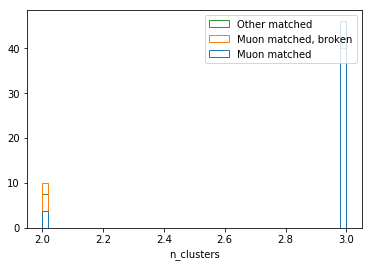

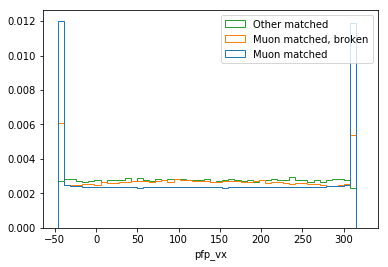

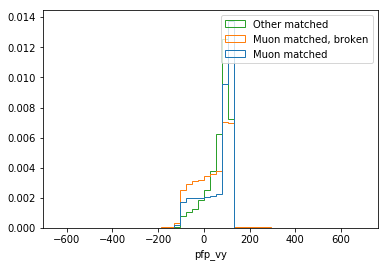

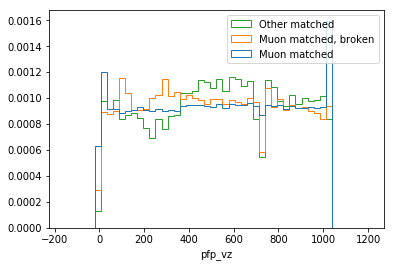

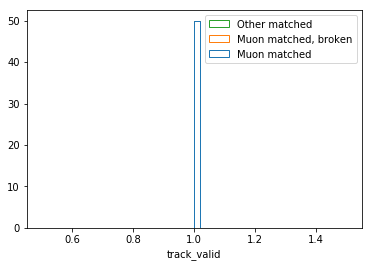

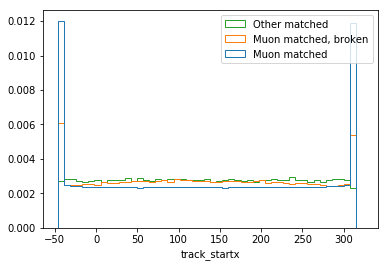

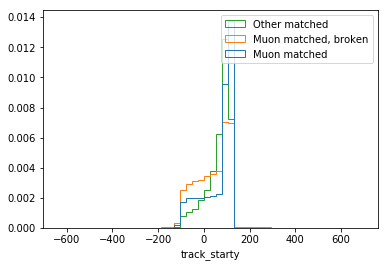

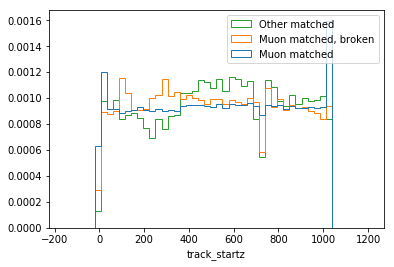

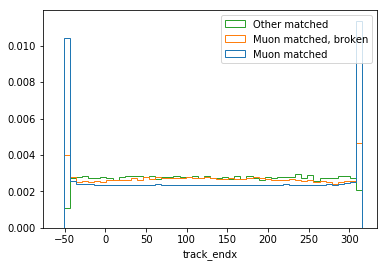

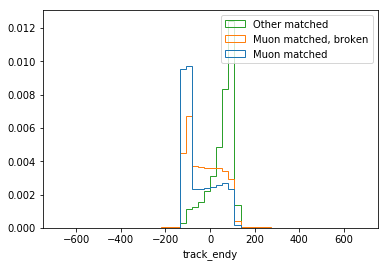

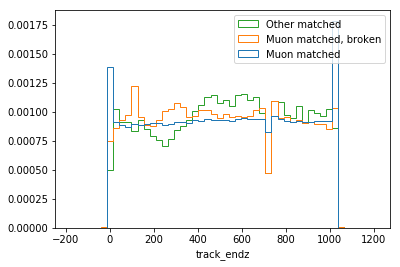

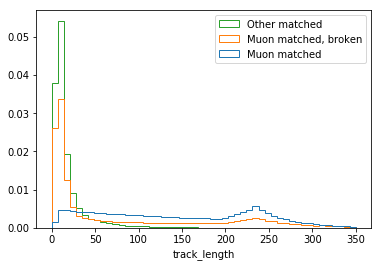

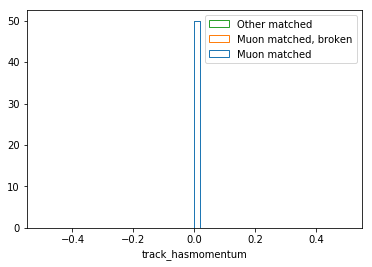

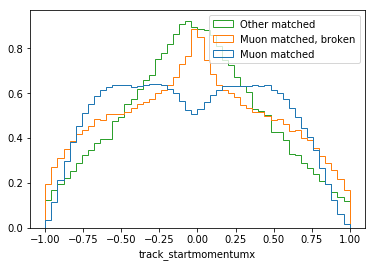

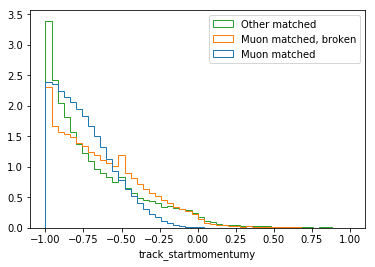

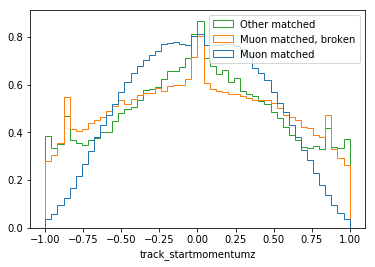

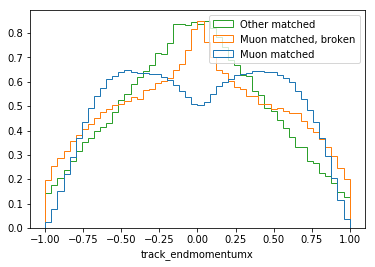

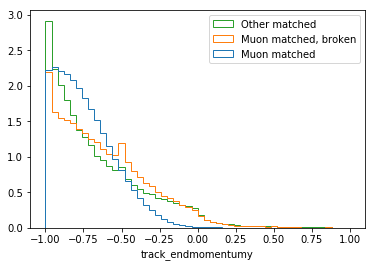

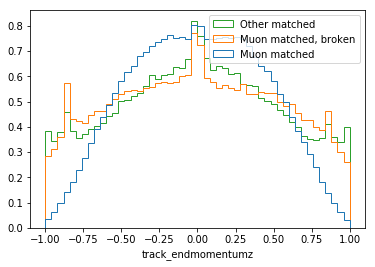

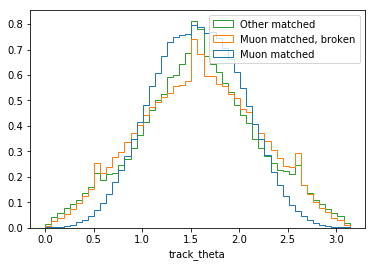

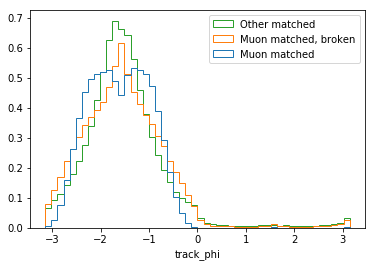

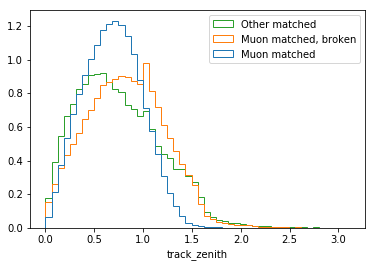

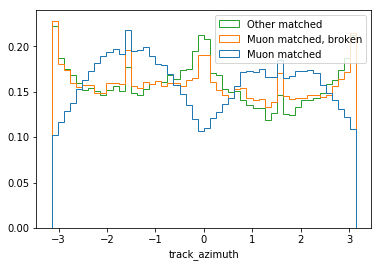

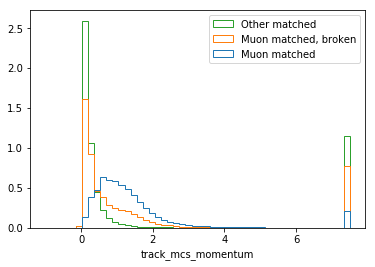

In [28]:
fields = [ 'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
           'track_startx', 'track_starty', 'track_startz', 'track_endx',
           'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
           'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
           'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
           'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
           'track_mcs_momentum'
         ]


for field in fields:
    data = [df[field] for df in df_arr]
    if field=='track_length':
        plt.hist(data, histtype='step',label=label_arr,density=1, bins=50, range=(0,350))
    else:
        plt.hist(data, histtype='step',label=label_arr,density=1, bins=50)
    plt.legend()
    plt.xlabel(field)
    plt.show()

## Angular stuff

[1, 1.9544982379298348]
[1, 1.9544982379298348]


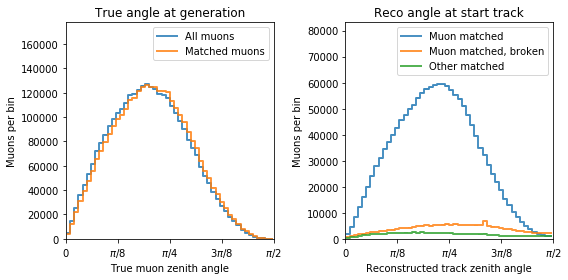

In [29]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))

N=50
x_min=0
x_max=np.pi/2*1.0

data=[df_mc_muon_cross['mc_zenith_true'], df_mc_muon_cross_matched['mc_zenith_true']]
labs=['All muons', 'Matched muons']
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
scale = [1, len(df_mc_muon_cross)/len(df_mc_muon_cross_matched)]

for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    print(scale)
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
ax[0].legend()
ax[0].set_xlabel(r'True muon zenith angle')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_xlim(x_min,x_max)
ax[0].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[0].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_title('True angle at generation')
ax[0].set_ylim(0, max_y*1.4)


data = [df['pfp_zenith_start'] for df in df_arr]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for bins_i, err_i, lab_i in zip(bins,err,label_arr):
    ax[1].step(edges_mid,bins_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[1].fill_between(edges_mid, bins_i - err_i, bins_i + err_i, alpha=0.3, step='mid')
ax[1].legend(loc='upper right')
ax[1].set_xlabel(r'Reconstructed track zenith angle')
ax[1].set_ylabel(r'Muons per bin')
ax[1].set_xlim(x_min,x_max)
ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_title('Reco angle at start track')
ax[1].set_ylim(0, max_y*1.4)

fig.tight_layout()
plt.savefig(outdir+"trackzenith_start.pdf", bbox_inches="tight")

-88726378.0576183


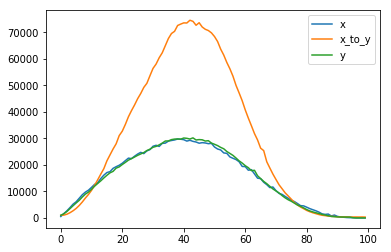

In [30]:
# Unfolding try-out
x = df_pfp_mc.query(clean_query)['mc_zenith_true']
y = df_pfp_mc.query(clean_query)['pfp_zenith_traj']

h,_,_ = np.histogram2d(y,x,bins=100, range=((0,np.pi/2),(0,np.pi/2)), normed=True)

x_hist,_ = np.histogram(x, bins=100, range=(0,np.pi/2))
h=np.array(h)
x_to_y_hist = np.dot(h,x_hist)
y_hist,_ = np.histogram(y/1.05, bins=100, range=(0,np.pi/2))

print(sum(y_hist-x_to_y_hist))
plt.plot(x_hist, label='x')
plt.plot(x_to_y_hist/30, label='x_to_y')
plt.plot(y_hist, label='y')
plt.legend()

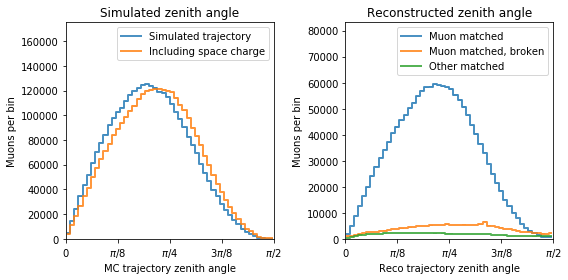

In [31]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))

N=50
x_min=0
x_max=np.pi/2*1.0

data=[df_mc_muon_cross['mc_zenith_traj'], df_mc_muon_cross_matched['mc_zenith_traj']]
labs=['Simulated trajectory', 'Including space charge']
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)

for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
ax[0].legend()
ax[0].set_xlabel(r'MC trajectory zenith angle')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_xlim(x_min,x_max)
ax[0].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[0].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_title('Simulated zenith angle')
ax[0].set_ylim(0, max_y*1.4)


data = [df['pfp_zenith_traj'] for df in df_arr]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for bins_i, err_i, lab_i in zip(bins,err,label_arr):
    ax[1].step(edges_mid,bins_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[1].fill_between(edges_mid, bins_i - err_i, bins_i + err_i, alpha=0.3, step='mid')
ax[1].legend(loc='upper right')
ax[1].set_xlabel(r'Reco trajectory zenith angle')
ax[1].set_ylabel(r'Muons per bin')
ax[1].set_xlim(x_min,x_max)
ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_title('Reconstructed zenith angle')
ax[1].set_ylim(0, max_y*1.4)

fig.tight_layout()
plt.savefig(outdir+"trackzenith_tpctraj.pdf", bbox_inches="tight")

[8.43607927 6.13982886 4.10122943 3.84984611 3.50397361 3.48022321
 3.19972398 3.27862437 3.01317553 2.66571421 2.85893979 2.25437236
 2.37492467 2.60146174 2.97077652 2.91256009 3.02222635 3.53605301
 3.31248378 4.0472822 ]


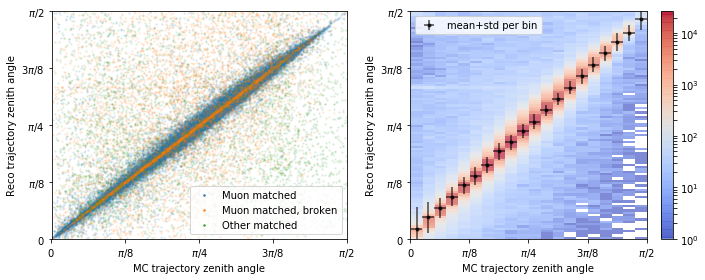

In [32]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey = False, figsize=(10,4))
fld_mc, fld_reco = 'mc_zenith_traj', 'pfp_zenith_traj'

for df,lab in zip(df_arr,label_arr):
    temp = df.sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],
                  temp[fld_reco],s=2,alpha=0.1,label=lab)
leg = ax[0].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0][fld_mc],df_arr[0][fld_reco], 
                                    label = label_arr[0], cmap='coolwarm', bins=(20,100), alpha= 0.65,norm=colors.LogNorm())
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n, xi, xf in zip(h,x_edges[:-1], x_edges[1:]):
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    mean = np.average(mids_y, weights=n)
    #var = np.average((mids_y - mean)**2, weights=n)
    mean = mids_y[np.argmax(n)]
    q_on=0
    df_temp = df_arr[0].query('(time_drift_ok>@q_on) & (mc_azimuth_traj>@xi) & (mc_azimuth_traj<@xf)')
    std = circstd(df_temp[fld_reco]-df_temp[fld_mc],low=-np.pi, high=np.pi)
    y_err.append(std)
    y_mean.append(mean)
print(np.array(y_err)/np.pi*180)
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mean+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')


ax[1].set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_xticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[1].set_yticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[1].set_yticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_yticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2])
ax[0].set_yticklabels([r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'])
ax[0].set_xlabel('MC trajectory zenith angle')
ax[0].set_ylabel('Reco trajectory zenith angle')
ax[1].set_xlabel('MC trajectory zenith angle')
ax[1].set_ylabel('Reco trajectory zenith angle')
ax[0].set_ylim(0,np.pi/2)

fig.tight_layout()
plt.savefig(outdir+"trackzenith_2d.png", bbox_inches="tight", dpi=300)

[13.80900564  7.97012344  7.51747929  7.61965974  8.01658901  8.72353317
  7.30512138  7.27496019  8.32483391 13.77370355 13.23749988  7.58563616
  6.5283264   7.13489252  9.22044383  8.46021778  7.22676444  6.54267038
  8.11234507 12.3064736 ]


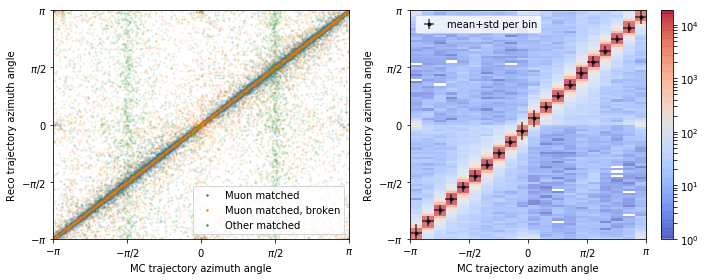

In [33]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=False, figsize=(10,4))
fld_mc, fld_reco = 'mc_azimuth_traj', 'pfp_azimuth_traj'

for df,lab in zip(df_arr,label_arr):
    temp = df.sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],temp[fld_reco],s=2,alpha=0.1,label=lab)
    leg = ax[0].legend(loc='lower right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0][fld_mc],df_arr[0][fld_reco], label = label_arr[0], 
                                    cmap='coolwarm', bins=(20,100), alpha= 0.65, norm=colors.LogNorm())
#,norm=colors.LogNorm())
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n, xi, xf in zip(h,x_edges[:-1], x_edges[1:]):
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    angles = np.repeat(mids_y,n.astype(int))
    mean = circmean(angles,low=-np.pi, high=np.pi)
    
    df_temp = df_arr[0].query('(time_drift_ok>@q_on) & (mc_azimuth_traj>@xi) & (mc_azimuth_traj<@xf)')
    std = circstd(df_temp[fld_reco]-df_temp[fld_mc],low=-np.pi, high=np.pi)
    #std = circstd(angles-mean,low=-np.pi, high=np.pi)
    mpv = mids_y[np.argmax(n)]
    y_err.append(std)
    y_mean.append(mean)
print(np.array(y_err)/np.pi*180)
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mean+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')


ax[1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[1].set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[0].set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax[1].set_yticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])
ax[0].set_xlabel('MC trajectory azimuth angle')
ax[0].set_ylabel('Reco trajectory azimuth angle')
ax[1].set_xlabel('MC trajectory azimuth angle')
ax[1].set_ylabel('Reco trajectory azimuth angle')
ax[0].set_ylim(-np.pi,np.pi)

fig.tight_layout()
plt.savefig(outdir+"trackazimuth_2d.png", bbox_inches="tight", dpi=300)

## Track length and momentum

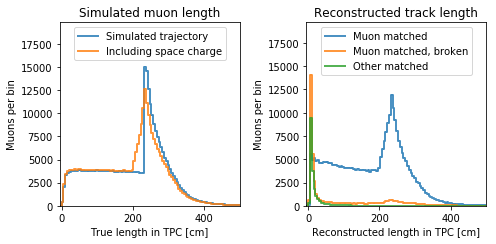

In [34]:
fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(7,3.5))

N=100
x_min=-5
x_max=500

data=[df_mc_muon_cross_matched['track_matched_length_tpc'], 
      df_mc_muon_cross_matched['track_matched_length_sce']]
labs=['Simulated trajectory', 'Including space charge']
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
scale = [1/5,1/5]

for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
ax[0].legend(loc='upper center')
ax[0].set_xlabel(r'True length in TPC [cm]')
ax[0].set_ylabel(r'Muons per bin')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0, max_y/3.79)
ax[0].set_title("Simulated muon length")

data = [df.query('time_drift_ok')['track_length'] for df in df_arr]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
for bins_i, err_i, lab_i in zip(bins,err,label_arr):
    ax[1].step(edges_mid,bins_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[1].fill_between(edges_mid, bins_i - err_i, bins_i + err_i, alpha=0.3, step='mid')
ax[1].legend(loc='upper center')
ax[1].set_xlabel(r'Reconstructed length in TPC [cm]')
ax[1].set_ylabel(r'Muons per bin')
ax[1].set_xlim(x_min,x_max)
ax[1].set_ylim(0, max_y*1.4)
ax[1].set_title("Reconstructed track length")

fig.tight_layout()
plt.savefig(outdir+"tracklength.pdf", bbox_inches="tight")

[  2.16003282   3.22343528   5.45699614  11.84647049  21.60053207
  31.45705276  42.85753701  54.49260068  54.14027304  59.6764499
  85.14821588 103.63601073 115.21913549 123.34960547 130.82748101
 138.24017809 149.15698751 160.33680825 166.02335803 176.87141477]
[2.03891438 2.35083861 2.56370177 2.73269405 2.80409246 2.89588301
 2.98549461 2.84534517 2.48912335 2.236554   2.0753024  2.1940588
 2.11598822 2.27338008 2.80334094 3.28484489 3.97774597 4.15583557
 3.82368152 4.52388468]


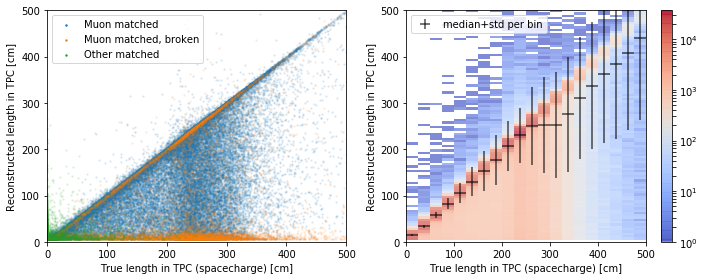

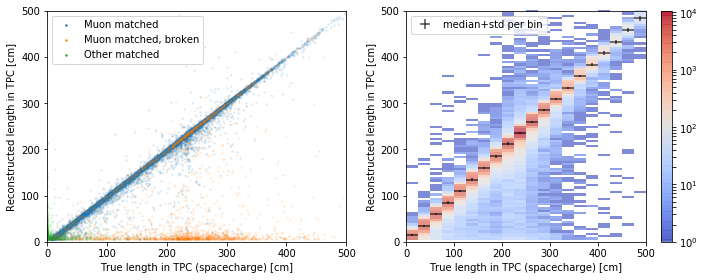

In [35]:
y_max = 500
for q_on, name in zip([-1,0], ['all', 'good']):
    fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=False, figsize=(10,4))
    fld_mc, fld_reco = 'track_matched_length_sce', 'track_length'

    for df,lab in zip(df_arr,label_arr):
        temp = df.query('time_drift_ok>@q_on').sample(frac=scatter_fraq)
        ax[0].scatter(temp[fld_mc],
                      temp[fld_reco],s=2,alpha=0.1,label=lab)
        leg = ax[0].legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

    h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0].query('time_drift_ok>@q_on')[fld_mc],df_arr[0].query('time_drift_ok>@q_on')[fld_reco], label = label_arr[0], 
                                        cmap='coolwarm', bins=(20,100), alpha= 0.65, norm=colors.LogNorm(), range=((0,y_max),(0,y_max)))
    #,norm=colors.LogNorm())
    clb = fig.colorbar(im, ax=ax[1])

    mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
    x_width = x_edges[1] - x_edges[0]
    y_mean = []
    y_err = []
    for n, xi, xf in zip(h,x_edges[:-1], x_edges[1:]):
        #mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
        #mean = np.average(mids_y, weights=n)
        #mpv = mids_y[np.argmax(n)]
        df_temp = df_arr[0].query('(time_drift_ok>@q_on) & (track_matched_length_sce>@xi) & (track_matched_length_sce<@xf)')
        percentiles = np.percentile(df_temp[fld_reco]-df_temp[fld_mc],[per1,per2])
        median = np.percentile(df_temp[fld_reco],50)
        std= (percentiles[1]-percentiles[0])/2
        y_err.append(std)
        y_mean.append(median)
    print(np.array(y_err))
    ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='none', label='median+std per bin', alpha=0.7)
    ax[1].legend(loc='upper left')

    ax[0].set_xlabel('True length in TPC (spacecharge) [cm]')
    ax[0].set_ylabel('Reconstructed length in TPC [cm]')
    ax[1].set_xlabel('True length in TPC (spacecharge) [cm]')
    ax[1].set_ylabel('Reconstructed length in TPC [cm]')
    ax[0].set_ylim(0,y_max)
    
    fig.tight_layout()
    plt.savefig(outdir+"tracklength_2d_"+name+"timing.png", bbox_inches="tight", dpi=300)

## Data MC Plots

In [36]:
track_zenith = {
    "name": 'pfp_zenith_traj',
    "bins": 100,
    "x_min": 0,
    "x_max": np.pi/2,
    "x_label": r"Zenith angle of reconstructed track [rad]",
    "x_ticks": [0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2],
    "x_labels": [r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2']
}

track_azimuth = {
    "name": 'pfp_azimuth_traj',
    "bins": 100,
    "x_min": -np.pi,
    "x_max": np.pi,
    "x_label": r"Azimuthal angle of reconstructed track [rad]",
    "x_ticks": [-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],
    "x_labels": [r"$-\pi$", r"$-3\pi/4$", r"$-\pi/2$", r"$-\pi/4$", "0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"]
}

track_length = {
    "name": 'track_length',
    "bins": 100,
    "x_min": 0,
    "x_max": 350,
    "x_label": r"Track length [cm]",
}

track_starty = {
    "name": 'track_starty',
    "bins": 100,
    "x_min": -120,
    "x_max": 120,
    "x_label": r"Track start y [cm]",
}

track_endy = {
    "name": 'track_endy',
    "bins": 100,
    "x_min": -115,
    "x_max": 115,
    "x_label": r"Track end y [cm]",
}

list_plot = [track_zenith, track_azimuth, track_length, track_starty, track_endy]

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


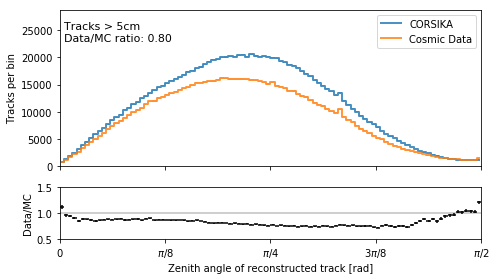

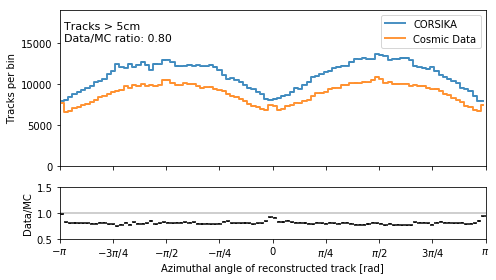

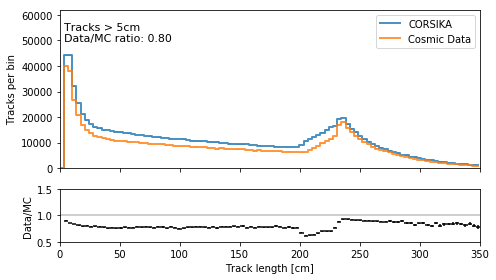

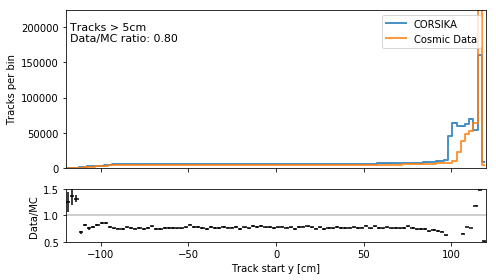

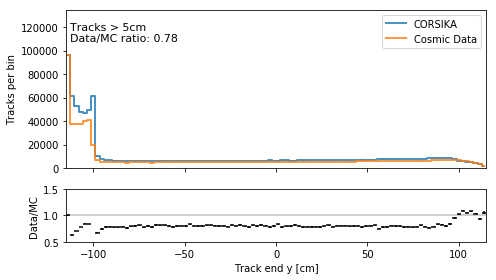

In [37]:
clean = False

scale = [mc_scale, 1]

for s in list_plot:
    fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(7,4), gridspec_kw = {'height_ratios':[3, 1]})
    if clean:
        data = [df_pfp_mc.query(clean_query)[s["name"]], df_pfp_data.query(clean_query)[s["name"]]]
    else:
        data = [df_pfp_mc[s["name"]], df_pfp_data[s["name"]]]
    edges, edges_mid, bins, err, max_y = histHelper(s["bins"], s["x_min"], s["x_max"], data)
    labs=['CORSIKA', 'Cosmic Data']
    for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
        ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
        ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
        
    ax[0].set_ylim(0,max_y*1.4*mc_scale)
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_xlim(s["x_min"],s["x_max"])
    ax[0].legend(loc='upper right')
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"] )
    
    ratio = bins[1]/(bins[0]*scale[0])
    ratio_err = 1/np.sqrt(bins[1]) #only do the error on data, mc error is super tiny
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')
    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    plt.tight_layout()
    text_x = s["x_min"]+(s["x_max"]-s["x_min"])*0.01
    if clean:
        ax[0].text(text_x, ax[0].get_ylim()[1]*0.8, 'Tracks > 25cm\n'+r"Data/MC ratio: {0:.2f}".format(sum(bins[1])/sum(bins[0]*scale[0])), fontsize=11)
        plt.savefig(outdir+s["name"]+"_25cm.pdf")
    else:
        ax[0].text(text_x, ax[0].get_ylim()[1]*0.8, 'Tracks > 5cm\n'+r"Data/MC ratio: {0:.2f}".format(sum(bins[1])/sum(bins[0]*scale[0])), fontsize=11)
        plt.savefig(outdir+s["name"]+"_5cm.pdf")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


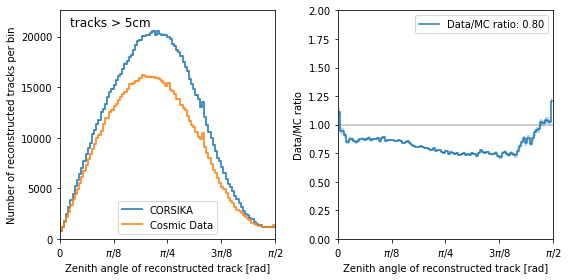

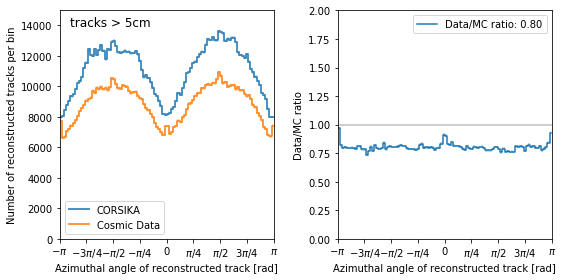

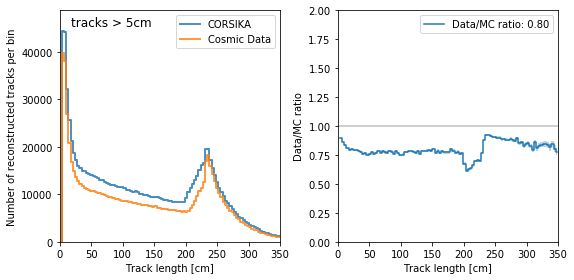

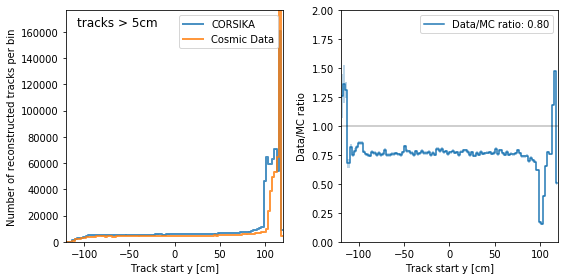

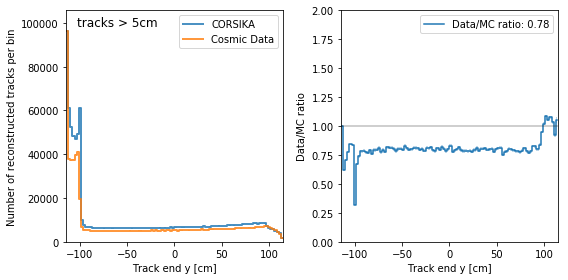

In [38]:
clean = False

scale = [mc_scale, 1]

for s in list_plot:
    fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8,4))
    if clean:
        data = [df_pfp_mc.query(clean_query)[s["name"]], df_pfp_data.query(clean_query)[s["name"]]]
    else:
        data = [df_pfp_mc[s["name"]], df_pfp_data[s["name"]]]
    edges, edges_mid, bins, err, max_y = histHelper(s["bins"], s["x_min"], s["x_max"], data)
    labs=['CORSIKA', 'Cosmic Data']
    for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
        ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
        ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')
        
    ax[0].set_ylim(0,max_y*1.1*mc_scale)
    ax[0].set_xlabel(s["x_label"])
    ax[0].set_ylabel("Number of reconstructed tracks per bin")
    ax[0].set_xlim(s["x_min"],s["x_max"])
    ax[0].legend()
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"] )
    
    ratio = bins[1]/(bins[0]*scale[0])
    ratio_err = 1/np.sqrt(bins[1]) #only do the error on data, mc error is super tiny
    ax[1].step(edges_mid, ratio, where='mid', label = r"Data/MC ratio: {0:.2f}".format(sum(bins[1])/sum(bins[0]*scale[0])))
    ax[1].fill_between(edges_mid, ratio -ratio_err, ratio +ratio_err, alpha=0.3, step='mid')
    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC ratio")
    ax[1].set_ylim(0.0,2.0)
    ax[1].legend()
    plt.tight_layout()
    text_x = s["x_min"]+(s["x_max"]-s["x_min"])*0.05
    if clean:
        ax[0].text(text_x, ax[0].get_ylim()[1]*0.93, 'tracks > 25cm', fontsize=12)
        plt.savefig(outdir+s["name"]+"_25cm.pdf")
    else:
        ax[0].text(text_x, ax[0].get_ylim()[1]*0.93, 'tracks > 5cm', fontsize=12)
        plt.savefig(outdir+s["name"]+"_5cm.pdf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


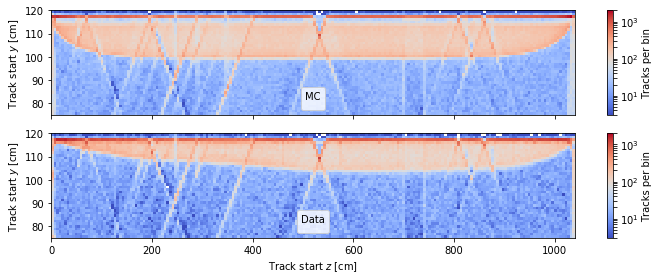

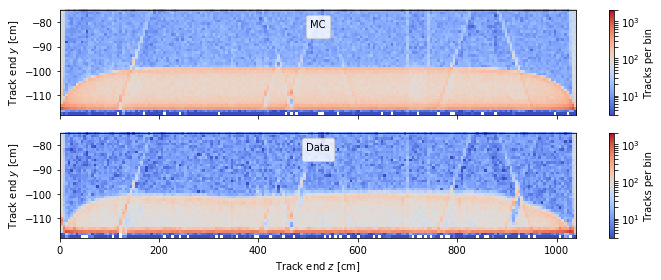

In [39]:
## 2D plot of the YZ boundary to look at the start point!

fig, ax = plt.subplots(nrows = 2, sharex=True, sharey=True, figsize=(10,4))

n_bins = (200,40)
yzrange = ((0,1040),(75,120))
mc_weights = [mc_scale]*len(df_pfp_mc['track_starty'])

h,x_edges,y_edges,im = ax[0].hist2d(df_pfp_mc['track_startz'], df_pfp_mc['track_starty'], weights=mc_weights,
                                    cmap='coolwarm', bins=n_bins, vmax=2000, vmin=3,
                                    norm=colors.LogNorm(), range=yzrange)
h,x_edges,y_edges,im = ax[1].hist2d(df_pfp_data['track_startz'], df_pfp_data['track_starty'],
                                    cmap='coolwarm', bins=n_bins, vmax=2000, vmin=3,
                                    norm=colors.LogNorm(), range=yzrange)
clb = fig.colorbar(im, ax=ax[0], label='Tracks per bin')
clb = fig.colorbar(im, ax=ax[1], label='Tracks per bin')
ax[0].legend(loc='lower center', title='MC')
ax[1].legend(loc='lower center', title='Data')
ax[1].set_xlabel(r'Track start $z$ [cm]')
ax[0].set_ylabel(r'Track start $y$ [cm]')
ax[1].set_ylabel(r'Track start $y$ [cm]')

fig.tight_layout()
fig.savefig(outdir+"2d_track_start.pdf", bbox_inches="tight")

###########################

fig, ax = plt.subplots(nrows = 2, sharex=True, sharey=True, figsize=(10,4))

n_bins = (200,40)
yzrange = ((0,1040),(-118,-75))
mc_weights = [mc_scale]*len(df_pfp_mc['track_endy'])

h,x_edges,y_edges,im = ax[0].hist2d(df_pfp_mc['track_endz'], df_pfp_mc['track_endy'], weights=mc_weights,
                                    cmap='coolwarm', bins=n_bins, vmax=2000, vmin=3,
                                    norm=colors.LogNorm(), range=yzrange)
h,x_edges,y_edges,im = ax[1].hist2d(df_pfp_data['track_endz'], df_pfp_data['track_endy'],
                                    cmap='coolwarm', bins=n_bins, vmax=2000, vmin=3,
                                    norm=colors.LogNorm(), range=yzrange)
clb = fig.colorbar(im, ax=ax[0], label='Tracks per bin')
clb = fig.colorbar(im, ax=ax[1], label='Tracks per bin')
ax[0].legend(loc='upper center', title='MC')
ax[1].legend(loc='upper center', title='Data')
ax[1].set_xlabel(r'Track end $z$ [cm]')
ax[0].set_ylabel(r'Track end $y$ [cm]')
ax[1].set_ylabel(r'Track end $y$ [cm]')

fig.tight_layout()
fig.savefig(outdir+"2d_track_end.pdf", bbox_inches="tight")

## Demonstrate that MCS momentum is not working well

[0.17752047 0.36211195 0.53470742 0.6563002  0.70403489 0.7546599
 0.7576578  0.75690969 0.76291087 0.78776392 0.77372795 0.76092705
 0.78934161 0.784853   0.7512866  0.77637693 0.75828322 0.76459619
 0.78975918 0.78984177]


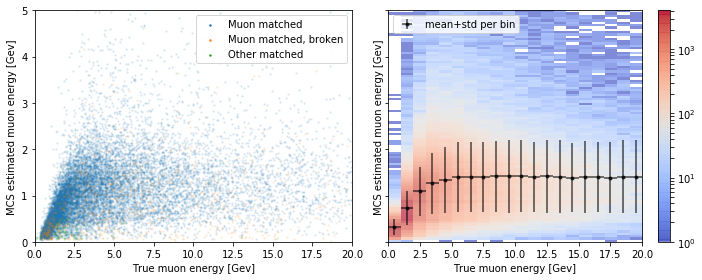

In [40]:
fig, ax = plt.subplots(ncols = 2, sharex=True, sharey=True, figsize=(10,4))
fld_mc, fld_reco = 'track_matched_energy', 'track_mcs_energy'

q_on=0
for df,lab in zip(df_arr,label_arr):
    temp = df.query('time_drift_ok>@q_on').query(clean_query).sample(frac=scatter_fraq)
    ax[0].scatter(temp[fld_mc],
                  temp[fld_reco],s=2,alpha=0.1,label=lab)
    leg = ax[0].legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
h,x_edges,y_edges,im = ax[1].hist2d(df_arr[0].query(clean_query).query('time_drift_ok>@q_on')[fld_mc],
                                    df_arr[0].query(clean_query).query('time_drift_ok>@q_on')[fld_reco], 
                                    label = label_arr[0], cmap='coolwarm', bins=(20,100), alpha= 0.65, 
                                    norm=colors.LogNorm(), range=((0,20),(0,5)))
clb = fig.colorbar(im, ax=ax[1])

mids_x = 0.5*(x_edges[1:] + x_edges[:-1])
x_width = x_edges[1] - x_edges[0]
y_mean = []
y_err = []
for n in h:
    mids_y = 0.5*(y_edges[1:] + y_edges[:-1])
    mean = np.average(mids_y, weights=n)
    var = np.average((mids_y - mean)**2, weights=n)
    y_err.append(np.sqrt(var))
    y_mean.append(mean)
print(np.array(y_err))
ax[1].errorbar(mids_x,y_mean, xerr=x_width/2, yerr=y_err,color='k', fmt='.', label='mean+std per bin', alpha=0.7)
ax[1].legend(loc='upper left')

ax[0].set_xlabel('True muon energy [Gev]')
ax[0].set_ylabel('MCS estimated muon energy [Gev]')
ax[1].set_xlabel('True muon energy [Gev]')
ax[1].set_ylabel('MCS estimated muon energy [Gev]')
    
fig.tight_layout()
plt.savefig(outdir+"mcs_2d_25_goodtime.png", bbox_inches="tight", dpi=300)

## Reconstructed vertex resolution (MC)

In [41]:
startx = {
    "field1": 'track_startx',
    "field2": 'track_matched_startx_sce',
    "field3": 'track_matched_startx',
    "bins": 50,
    "x_min": -25,
    "x_max": 25,
    "x_label": r"Start $x$ track: Reco - Truth [cm]"
}

starty = {
    "field1": 'track_starty',
    "field2": 'track_matched_starty_sce',
    "field3": 'track_matched_starty',
    "bins": 50,
    "x_min": -25,
    "x_max": 25,
    "x_label": r"Start $y$ track: Reco - Truth [cm]"
}

startz = {
    "field1": 'track_startz',
    "field2": 'track_matched_startz_sce',
    "field3": 'track_matched_startz',
    "bins": 50,
    "x_min": -25,
    "x_max": 25,
    "x_label": r"Start $z$ track: Reco - Truth [cm]"
}


endx = {
    "field1": 'track_endx',
    "field2": 'track_matched_endx_sce',
    "field3": 'track_matched_endx',
    "bins": 50,
    "x_min": -25,
    "x_max": 25,
    "x_label": r"End $x$ track: Reco - Truth [cm]"
}

endy = {
    "field1": 'track_endy',
    "field2": 'track_matched_endy_sce',
    "field3": 'track_matched_endy',
    "bins": 50,
    "x_min": -25,
    "x_max": 25,
    "x_label": r"End $y$ track: Reco - Truth [cm]"
}

endz = {
    "field1": 'track_endz',
    "field2": 'track_matched_endz_sce',
    "field3": 'track_matched_endz',
    "bins": 50,
    "x_min": -25,
    "x_max": 25,
    "x_label": r"End $z$ track: Reco - Truth [cm]"
}

list_plot = [startx, starty, startz,
             endx, endy, endz]

tolerance = 5

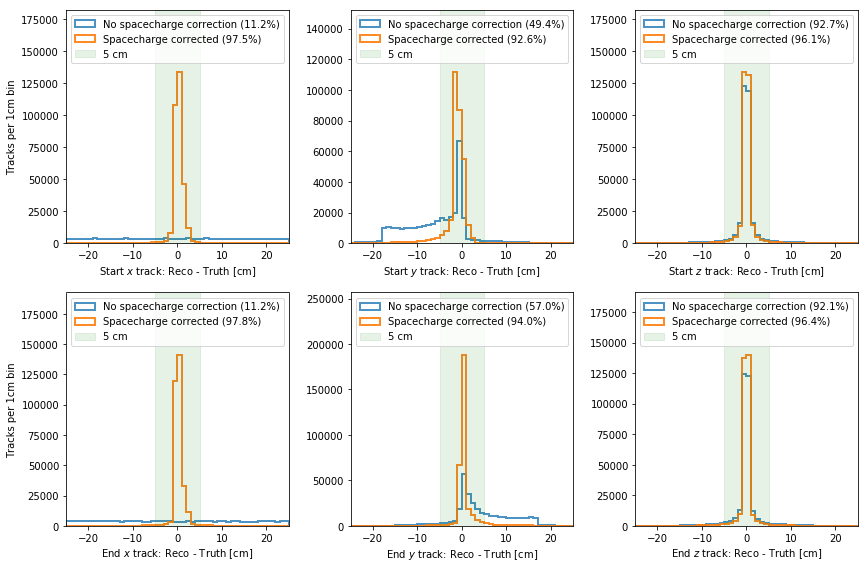

In [42]:
# Make a plot to test the spacecharge for muon matched tracks
# Inpose the timing cut to ensure full drift availibility

fig, ax = plt.subplots(nrows=2, ncols = 3, figsize=(12.2,8))
ax = ax.flatten()

q_on=0

for i, d in enumerate(list_plot):
    if 'field3' in d:
        data = [df.query('time_drift_ok>@q_on')[d['field1']]- 
                df.query('time_drift_ok>@q_on')[d['field3']] for df in df_arr]
        
        ratio = sum((data[0]<tolerance)&(data[0]>-1*tolerance))/len(data[0])*100
        ax[i].hist(data[0], histtype='step',density=0, lw=2, alpha=0.8,
                   bins=d['bins'], range=(d['x_min'], d['x_max']), 
                   label= 'No spacecharge correction ({0:.1f}%)'.format(ratio))
        
    data = [df.query('time_drift_ok>@q_on')[d['field1']]-
            df.query('time_drift_ok>@q_on')[d['field2']] for df in df_arr]
    ratio = sum((data[0]<tolerance)&(data[0]>-1*tolerance))/len(data[0])*100
    ax[i].hist(data[0], histtype='step',density=0, lw=2, alpha=0.9,
               bins=d['bins'], range=(d['x_min'], d['x_max']),
               label= 'Spacecharge corrected ({0:.1f}%)'.format(ratio))
    ax[i].axvspan(-1*tolerance, tolerance, color="green", label=str(tolerance)+' cm', alpha=0.1)
    ax[i].set_xlabel(d['x_label'])
    ax[i].legend(loc= 'upper center')
    ax[i].set_ylim(0,1.3*ax[i].get_ylim()[1])
    ax[i].set_xlim(d['x_min'], d['x_max'])
    
ax[0].set_ylabel("Tracks per 1cm bin")
ax[3].set_ylabel("Tracks per 1cm bin")
fig.tight_layout()
fig.savefig(outdir+"start_end_resolution.pdf", bbox_inches="tight")

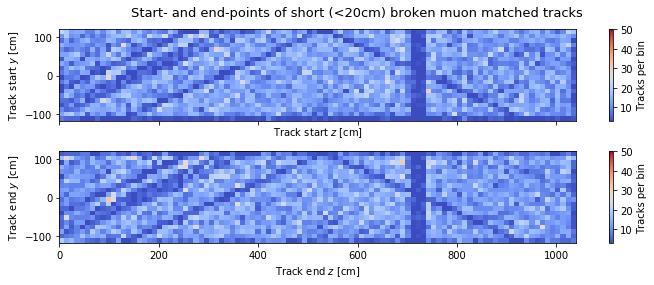

In [72]:
# Dataframe of broken muon trakcs with length under 20 cm and matched to muons within full drift window:
q_on=0
df_temp = df_arr[1].query('track_length<20').query('time_drift_ok>@q_on')


fig, ax = plt.subplots(nrows = 2, sharex=True, sharey=False, figsize=(10,4))

n_bins = (100,20)
yzrange = ((0,1040),(-118,120))
h,x_edges,y_edges,im = ax[0].hist2d(df_temp['track_startz'], df_temp['track_starty'],
                                    cmap='coolwarm', bins=n_bins, vmax=50, vmin=3,
                                    range=yzrange)

n_bins = (100,20)
yzrange = ((0,1040),(-118,120))
h,x_edges,y_edges,im = ax[1].hist2d(df_temp['track_endz'], df_temp['track_endy'],
                                    cmap='coolwarm', bins=n_bins, vmax=50, vmin=3,
                                    range=yzrange)

clb = fig.colorbar(im, ax=ax[0], label='Tracks per bin')
clb = fig.colorbar(im, ax=ax[1], label='Tracks per bin')
ax[0].set_xlabel(r'Track start $z$ [cm]')
ax[1].set_xlabel(r'Track end $z$ [cm]')
ax[0].set_ylabel(r'Track start $y$ [cm]')
ax[1].set_ylabel(r'Track end $y$ [cm]')

fig.suptitle('Start- and end-points of short (<20cm) broken muon matched tracks',fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig(outdir+"start_end_broken20cm.pdf", bbox_inches="tight")